In [1]:
import scipy

from keras.layers import BatchNormalization, Add, add, Input, Dense, Reshape, Flatten, Dropout, Concatenate, LeakyReLU
from keras.layers import UpSampling2D, Conv2D
from keras.applications import vgg19
import tensorflow 
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import os
import keras.backend as K
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
img_width = 256
img_height = 256  # размер, к которому будем преобразовывать изображения 

In [3]:
directory = 'H:\Segment\Airplanes'

In [4]:
real_img = 'img'
seg_mask = 'mask'

In [5]:
def open_file(type_img): # фукнция извлечения файлов из папок
    images = []
    for filename in sorted(os.listdir(directory + '\\' + f'{type_img}' )):      
        images.append(image.load_img(f'H:\\Segment\\airplanes\\{type_img}\\{filename}',
                                       target_size=(img_width, img_height)))
    print (f'Количество изображений {type_img}:  ', len(images))
    return images 

In [6]:
imgs = open_file(real_img)
masks = open_file(seg_mask)

Количество изображений img:   1000
Количество изображений mask:   1000


In [7]:
def img_to_np(data): # функция перевода изображения в массив numpy
    np_data = np.array([np.array(i) for i in data])
    return np_data

In [8]:
imgs = img_to_np(imgs)
masks = img_to_np(masks)

In [9]:
print(imgs.shape, masks.shape)

(1000, 256, 256, 3) (1000, 256, 256, 3)


In [30]:
img_shape = imgs[0].shape

In [49]:
def build_generator():
    gen_f = 64 #минимальное число фильтров
    
    def conv2d(layer_input, filters, window_size=4, B_N=True): #слой с понижением разрешения (encoder)
        
        d = Conv2D(filters, kernel_size=window_size, strides=2, padding='same')(layer_input) #strides = 2 уменьшает разрешение в 2 раза при padding='same'
        d = LeakyReLU(alpha=0.2)(d)
        if B_N:
            d = BatchNormalization(momentum=0.9)(d)
        return d
    
    def deconv2d(layer_input, skip_input, filters, window_size=4, dropout_prc=0): #слой с повышением разрешения (decoder) принимает на вход предыдущий слой и skip-слой от encoder'а
        u = UpSampling2D(size=2)(layer_input) #увеличивам разрешение в 2 раза
        u = Conv2D(filters, kernel_size=window_size, strides=1, padding='same', activation='relu')(u) #strides=1, padding='same',  поэтому разрешение сохраняется
        if dropout_prc:
            u = Dropout(dropout_prc)(u)
        u = BatchNormalization(momentum=0.9)(u)
        u = Concatenate()([u, skip_input]) #соединяем skip-слой и слой decoder'а
        return u  
    
    d0 = Input(shape=img_shape, name="condition") #входное изображение (условие)

    # Часть encoder'a
    d1 = conv2d(d0, gen_f, B_N=False)
    d2 = conv2d(d1, gen_f*2)
    d3 = conv2d(d2, gen_f*4) #чем меньше размер карт активаций
    d4 = conv2d(d3, gen_f*8) #тем больше должно быть фильтров в сверточном слое
    d5 = conv2d(d4, gen_f*8)
    d6 = conv2d(d5, gen_f*8)
    d7 = conv2d(d6, gen_f*8)

    # Часть decoder'a
    u1 = deconv2d(d7, d6, gen_f*8)
    u2 = deconv2d(u1, d5, gen_f*8) 
    u3 = deconv2d(u2, d4, gen_f*8) #чем больше размер карт активаций
    u4 = deconv2d(u3, d3, gen_f*4) #тем меньше должно быть фильтров в сверточном слое
    u5 = deconv2d(u4, d2, gen_f*2)
    u6 = deconv2d(u5, d1, gen_f)

    u7 = UpSampling2D(size=2)(u6)
    output_img = Conv2D(3, kernel_size=4, strides=1, padding='same', activation='tanh', name='G_output')(u7) #интенсивность должна быть от -1 до 1, поэтому используем tanh

    return Model(d0, output_img, name="G")
    

In [50]:
def build_discriminator():
    dis_f = 64
    def d_layer(layer_input, filters, window_size = 4, B_N = True): #слой дискриминатора с понижением разрешения
        
        d = Conv2D(filters, kernel_size = window_size, strides = 2, padding = 'same')(layer_input)
        d = LeakyReLU(alpha=0.3)(d)
        if B_N:
            d = BatchNormalization(momentum=0.9)(d)
        return d
    
    image = Input(shape=img_shape, name="real_or_fake_A") #на вход дискриминатору подается либо реальное изображение, либо фейковое
    condition = Input(shape=img_shape, name="condition") #и дополнительно изображение-условие
    
    combined_imgs = Concatenate(axis=-1)([image, condition]) #объединяем оба входа в 1 слой
    
    d1 = d_layer(combined_imgs, dis_f, B_N=False)
    d2 = d_layer(d1, dis_f*2)
    d3 = d_layer(d2, dis_f*4) #уменьшаем размер карт активации, увеличивая их число
    d4 = d_layer(d3, dis_f*8)
    
    validity = Conv2D(1, kernel_size=4, strides=1, padding='same', name='D_output', activation='sigmoid')(d4) #на выходе будет двумерный массив, каждый элемент которого определяет, подлинность части изображения (patch GAN)
                                                                                                              #0 отвечает за фейковые изображения, 1 за подлинные, поэтому используем sigmoid
        
    return Model([image, condition], validity, name='D')

In [51]:
def build_vgg():
    # воспользуемся обученной сетью VGG19, чтобы использовать ее как второй Дискриминатор
    vgg_in = Input(img_shape)
    vgg = vgg19.VGG19(include_top=False, input_shape=img_shape, input_tensor=vgg_in) #скачиваем архитектуру и веса 
    vgg_out = vgg.get_layer('block5_conv4').output #получаем последний сверточный слой
    vgg = Model(vgg_in, vgg_out, name='vgg')
    return vgg

In [52]:
def build_gan(generator, discriminator, vgg):
    
    discriminator.trainable = False #замораживаем дискриминатор
    
    vgg.trainable = False # замораживаем VGG19

    mask = Input(img_shape, name='mask') #вход изображения-условия (маска)
    
    fake_img = generator(mask) #изображение, полученное от генератора

    fake_features = vgg(fake_img) #карты активации, полученные от фейкового изображения

    fake_validity = discriminator([fake_img, mask]) #соединяем генератор и дискриминатор

    gan = Model(mask, [fake_validity, fake_img, fake_features]) 
    
    #получаем gan с тремя выходами: 
    #первый отвечает за "правдоподобность", второй за изображение от генератора, третий за карты активации

    return gan

In [53]:
def train(generator, discriminator, gan, vgg, imgs, masks, epochs, batch_size):

    for epoch in range(epochs): 
        idx = np.random.choice(imgs.shape[0], imgs.shape[0], replace=False) #перемешиваем индексы, чтобы batch'и всегда были разными

        with tqdm(total=imgs.shape[0]) as pbar: #для отслеживания создаем progressbar
            for batch in range(imgs.shape[0]//batch_size):
        
                #для тренировки дискриминатора применяем label smoothing
                #размерность Y: (размер батча, высота последнего слоя дискриминатора, ширина, 1)
                y_real = np.ones((batch_size, *discriminator.output_shape[1:])) - np.random.random_sample((batch_size, *discriminator.output_shape[1:]))*0.2
                y_fake = np.random.random_sample((batch_size, *discriminator.output_shape[1:]))*0.2

                idx_batch = idx[batch*batch_size:(batch+1)*batch_size] #получаем индексы для одного batch'а

                real_imgs = (imgs[idx_batch]/127.5)-1 #получаем истинные изображения и нормализуем их
                condition = (masks[idx_batch]/127.5)-1 #получаем маски и нормализуем их

                fake_imgs = generator.predict(condition) #генерируем изображения по маскам

                #тренируем дискриминатор       
                d_loss_real = discriminator.train_on_batch([real_imgs, condition], y_real)
                d_loss_fake = discriminator.train_on_batch([fake_imgs, condition], y_fake)
                d_loss_total = 0.5*np.add(d_loss_real, d_loss_fake)

                #тренируем генератор
                real_features = vgg.predict(real_imgs)
                y_real = np.ones((batch_size, *discriminator.output_shape[1:]))

                g_loss = gan.train_on_batch(condition, [y_real, real_imgs, real_features])
                pbar.update(batch_size) #обновляем progressbar
                pbar.set_description("Epoch: {}/{}, Discriminator loss: {}, Generator loss:{}".format(epoch+1, epochs, d_loss_total[0], g_loss))

In [54]:
gen = build_generator() #создаем генератор

dis = build_discriminator() #создаем дискриминатор
dis.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-4, beta_1=0.5), metrics=['accuracy'])

vgg = build_vgg() #создаем vgg модель

gan = build_gan(gen, dis, vgg) #создаем gan
gan.compile(loss=['binary_crossentropy', 'mse', 'mse'], loss_weights=[1,100,10], optimizer=Adam(learning_rate=1e-4, beta_1=0.5)) #вклад разницы между пикселями в 10 раз больше, чем вклад от feature loss и в 100 раз больше, чем вклад от GAN

In [56]:
train(gen, dis, gan, vgg, imgs, masks, 30, 16) #тренируем модель

Epoch: 1/30, Discriminator loss: 0.6368373334407806, Generator loss:[16.051166534423828, 0.983627200126648, 0.1449175626039505, 0.057578232139348984]:  99%|█████████▉| 992/1000 [01:22<00:00, 12.04it/s]   
Epoch: 2/30, Discriminator loss: 0.5254426598548889, Generator loss:[17.91220474243164, 0.6433322429656982, 0.16742408275604248, 0.0526464581489563]:  99%|█████████▉| 992/1000 [01:22<00:00, 11.98it/s]   
Epoch: 3/30, Discriminator loss: 0.33203257620334625, Generator loss:[12.326181411743164, 0.6353676319122314, 0.11177034676074982, 0.051377955824136734]:  99%|█████████▉| 992/1000 [01:23<00:00, 11.87it/s]
Epoch: 4/30, Discriminator loss: 0.3397245705127716, Generator loss:[13.935531616210938, 0.5354024767875671, 0.12942470610141754, 0.04576587304472923]:  99%|█████████▉| 992/1000 [01:23<00:00, 11.82it/s]  
Epoch: 5/30, Discriminator loss: 1.492784321308136, Generator loss:[13.714497566223145, 0.988935112953186, 0.1227467805147171, 0.04508839547634125]:  99%|█████████▉| 992/1000 [01:24

In [57]:
def sample_image(generator, imgs, masks, idx): #отображаем маску, созданное и исходное изображения
    fig, ax = plt.subplots(1,3, figsize=(15,5)) #создаем сетку с 1 строкой и 3 столбцами


    ax[0].imshow(masks[idx]) #показываем маску
    ax[0].set_title('маска')
    
    condition = masks[idx]/127.5-1
    generated = (generator.predict(condition[None])+1)*127.5 #по маске генерируем изображение

    ax[1].imshow(generated[0].astype('uint8')) #показываем сгенерированное изображение
    ax[1].set_title('сгенерированное изображение')

    ax[2].imshow(imgs[idx]) #показываем исходное изображение
    ax[2].set_title('реальное изображение')

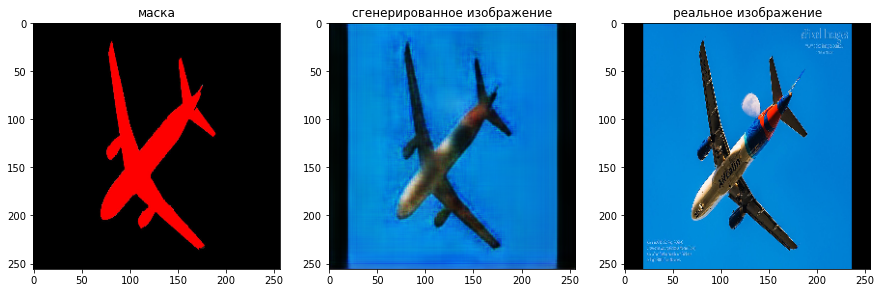

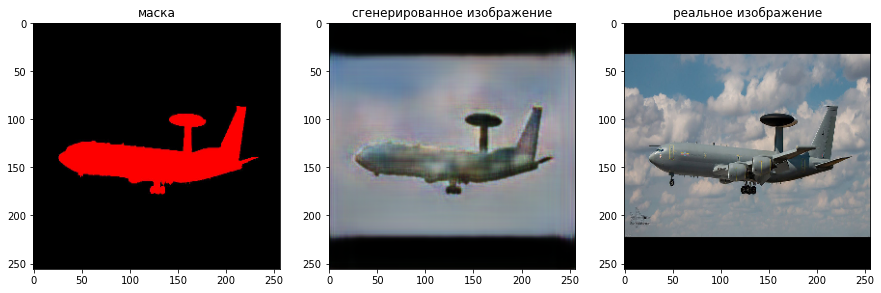

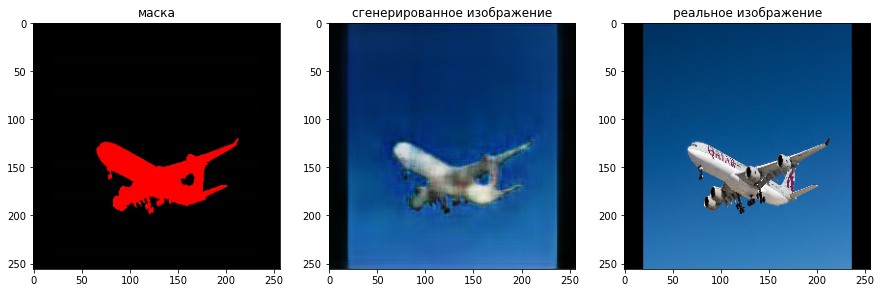

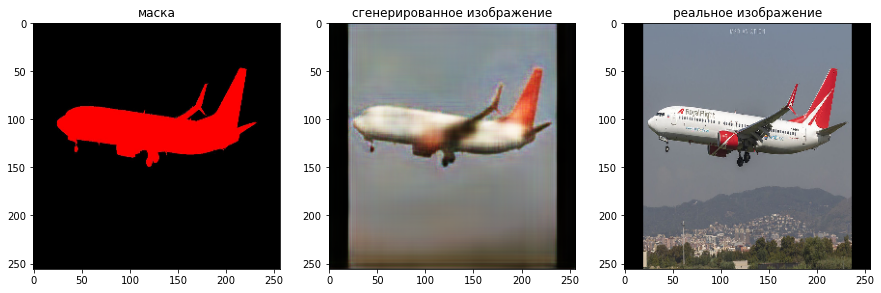

In [58]:
for i in [20,100,300,500]:
    sample_image(gen, imgs, masks, i)